<a href="https://colab.research.google.com/github/jg4726/public-file/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import torch
import time
from torch.functional import Tensor
from transformers import AdamW
from sklearn.metrics import roc_auc_score
import collections

In [ ]:
rng = np.random.default_rng(42)
torch.manual_seed(42) 

In [ ]:

cols = ['text','label']
lst= []
with open('assignment_4.txt', 'r') as fin:
    for line in fin:
        text, label = line.strip().rsplit('@', 1)
        lst.append([text,label])
    df=pd.DataFrame(lst,columns=cols)
df


,text,label
0,"According to Gran , the company has no plans t...",neutral
1,"For the last quarter of 2010 , Componenta 's n...",positive
2,"In the third quarter of 2010 , net sales incre...",positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive
...,...,...
2259,Operating result for the 12-month period decre...,negative
2260,HELSINKI Thomson Financial - Shares in Cargote...,negative
2261,LONDON MarketWatch -- Share prices ended lower...,negative
2262,Operating profit fell to EUR 35.4 mn from EUR ...,negative


Statistics= 752.7392335045438 p= 1.0
it is normally distributed


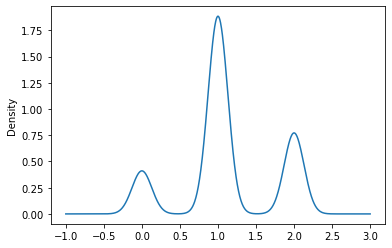

In [ ]:
from sklearn.preprocessing import LabelEncoder

le_label = LabelEncoder()
df['bi_label'] = le_label.fit_transform(df['label'])
new = df['bi_label']
from scipy.stats import chisquare
from scipy import stats
stat, p = chisquare(new)
print('Statistics=',stat, 'p=', p)
if p > 0.05:
	print('it is normally distributed')
else:
	print('not normally distributed')
import matplotlib.pyplot as plt
new.plot(kind='kde')
df =df.drop(['bi_label'],axis = 'columns')

In [ ]:
from sklearn.model_selection import train_test_split

x = df['text']

y= df['label']

x_train, x_test,y_train,y_test = train_test_split(x,y, test_size=0.3,stratify=y)

train_dataset = x_train.to_frame().join(y_train) #used for q2
train_dataset['bi_label'] = le_label.fit_transform(train_dataset['label'])
train_dataset =train_dataset.drop(['label'],axis = 'columns')
train_dataset=train_dataset.rename(columns={"bi_label": "label"})
train_dataset= train_dataset.reset_index()
train_dataset=train_dataset.drop(['index'], axis='columns')


test_dataset = x_test.to_frame().join(y_test)
test_dataset['bi_label'] = le_label.fit_transform(test_dataset['label'])
test_dataset =test_dataset.drop(['label'],axis = 'columns')
test_dataset=test_dataset.rename(columns={"bi_label": "label"})
test_dataset= test_dataset.reset_index()
test_dataset=test_dataset.drop(['index'], axis='columns')




le_label = LabelEncoder()
y_train = le_label.fit_transform(y_train)
y_test = le_label.fit_transform(y_test)

y_train_df = pd.DataFrame(y_train)
y_test_df = pd.DataFrame(y_test)
y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

#df =df.drop(['bi_label'],axis = 'columns')


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(min_df=1,ngram_range=(2, 2),binary=True,stop_words = 'english')

cx_train = vect.fit_transform(x_train)

cx_test = vect.transform(x_test)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect2 = TfidfVectorizer(min_df=1,ngram_range=(2, 2),stop_words = 'english')

fx_train = vect2.fit_transform(x_train)

fx_test = vect2.transform(x_test)



In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
tfidf = logreg.fit(fx_train,y_train)
tfifd_lr_pred = tfidf.predict_proba(fx_test)
#array_y_test = y_test.to_numpy()

cv = logreg.fit(cx_train,y_train)
cv_lr_pred = cv.predict_proba(cx_test)

from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
tb = bnb.fit(fx_train,y_train)
tb_pred = tfidf.predict_proba(fx_test)
#array_y_test = y_test.to_numpy()

cvb = bnb.fit(cx_train,y_train)
cvb_pred = cvb.predict_proba(cx_test)

<Figure size 1440x1440 with 0 Axes>

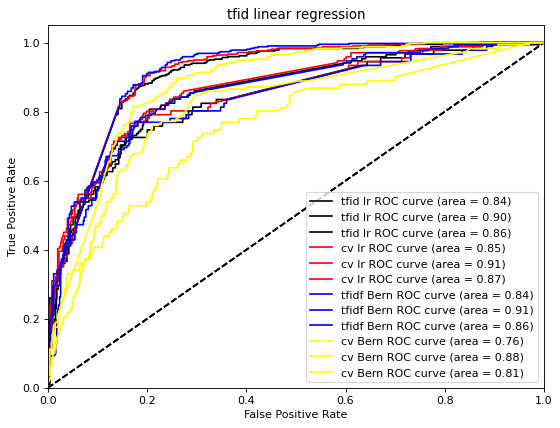

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize
from matplotlib.pyplot import figure


biy_test = label_binarize(y_test, classes=[0, 1, 2])
n_classes = 3

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(biy_test[:,i], tfifd_lr_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
plt.figure(figsize=(20,20))
figure(figsize=(8, 6), dpi=80)
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='tfid lr ROC curve (area = %0.2f)' % roc_auc[i],color = 'black')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('tfid linear regression')
    plt.legend(loc="lower right")
    
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(biy_test[:,i], cv_lr_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='cv lr ROC curve (area = %0.2f)' % roc_auc[i],color = 'red')
    plt.legend(loc="lower right")

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(biy_test[:,i], tb_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='tfidf Bern ROC curve (area = %0.2f)' % roc_auc[i],color = 'blue')
    plt.legend(loc="lower right")
    
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(biy_test[:,i], cvb_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='cv Bern ROC curve (area = %0.2f)' % roc_auc[i],color = 'yellow')
    plt.legend(loc="lower right")



In [ ]:
# Logistic regression model is better

In [ ]:

#Q2

import pandas as pd
import numpy as np
import torch
import time
from torch.functional import Tensor
from transformers import AdamW
from sklearn.metrics import roc_auc_score
import collections
from transformers import BertTokenizer, BertForSequenceClassification
import tensorflow as tf

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
from datasets import Dataset
new_train = Dataset.from_pandas(train_dataset)
new_eval  =new_train.shuffle(seed=42).select(range(300))

new_test = Dataset.from_pandas(test_dataset)


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length = 30)

t_train = new_train.map(tokenize_function, batched=True)
t_eval = new_eval.map(tokenize_function, batched=True)
t_test = new_test.map(tokenize_function, batched=True)


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:

new_t_train = t_train.remove_columns(["text"])
new_t_train = new_t_train.rename_column("label", "labels")
new_t_train.set_format("torch")


new_t_test = t_test.remove_columns(["text"])
new_t_test = new_t_test.rename_column("label", "labels")
new_t_test.set_format("torch")

new_t_eval = t_eval.remove_columns(["text"])
new_t_eval = new_t_eval.rename_column("label", "labels")
new_t_eval.set_format("torch")


new_t_eval

Dataset({
    features: ['attention_mask', 'input_ids', 'labels', 'token_type_ids'],
    num_rows: 300
})

In [ ]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(new_t_train, shuffle=True, batch_size=12)
eval_dataloader = DataLoader(new_t_eval, batch_size=12)
test_dataloader = DataLoader(new_t_test, batch_size=12)

from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

In [ ]:
from transformers import get_scheduler

num_epochs = 3  #my time is toolong
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

In [ ]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
from tqdm.auto import tqdm
from torch import tensor
import torch.nn.functional as F

progress_bar = tqdm(range(num_training_steps))
train_index = train_dataset.index.tolist()

model.train()
epoch_loss = []
train_probas = []
all_loss=[]
all_auc=[]
for epoch in range(num_epochs):
    rng.shuffle(train_index)
    epoch_loss = []
    train_probas = []
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        epoch_loss.append(loss.data.cpu().numpy())#get the loss for each round
        
        prob = F.softmax(outputs.logits, dim=1).cpu().detach().numpy()#get probability
        train_probas.extend(prob)#append
        
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()    
        progress_bar.update(1)
    np.array(train_probas)
    mean_loss = np.mean(epoch_loss)
    all_auc.append(roc_auc_score(train_dataset.loc[train_index,'label'], train_probas,multi_class='ovr'))
    all_loss.append(mean_loss)

  0%|          | 0/396 [00:00<?, ?it/s]

<AxesSubplot:title={'center':'All auc'}>

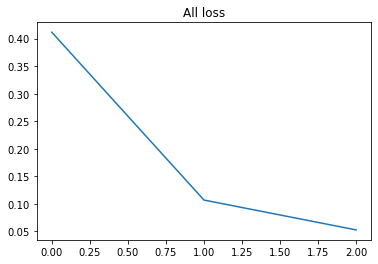

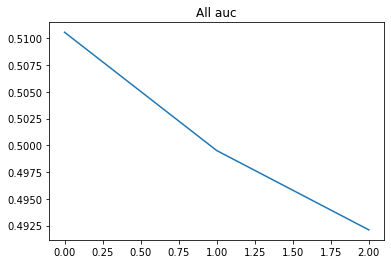

In [ ]:
#all loss chart
import matplotlib.pyplot as plt
plt1 = plt.figure(1)
plt.title('All loss')
pd.Series(all_loss, name="loss").plot(x=True, y=True)

#all auc chart
plt2 = plt.figure(2)
plt.title('All auc')
pd.Series(all_auc, name="auc").plot(x=True, y=True)

In [ ]:

from datasets import load_metric
metric= load_metric("accuracy")

#train_index = eval_dataset.index.tolist()


model.eval()

for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    #loss = outputs.loss
    #loss.backward()
    #eval_loss.append(loss.data.cpu().numpy())
    logits = outputs.logits
    #prob = F.softmax(logits, dim=1).cpu().detach().numpy()#get probability
    
    #train_probas.extend(prob)
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])
    #all_auc.append(roc_auc_score(test_dataset.loc[train_index,'label'], train_probas,multi_class='ovr'))
metric.compute()

{'accuracy': 0.9933333333333333}

In [ ]:
#roc for test set

model.eval()
test_probas = []
all_pred =[]
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    
    logits = outputs.logits
    prob = F.softmax(logits, dim=1).data.cpu().numpy()
    test_probas.extend(prob)

    
    predictions = torch.argmax(logits, dim=-1).data.cpu().numpy()
    all_pred.extend(predictions)
    metric.add_batch(predictions=predictions, references=batch["labels"])
finaltest_probas = np.array(test_probas)
final_pred = np.array(all_pred)

<Figure size 1440x1440 with 0 Axes>

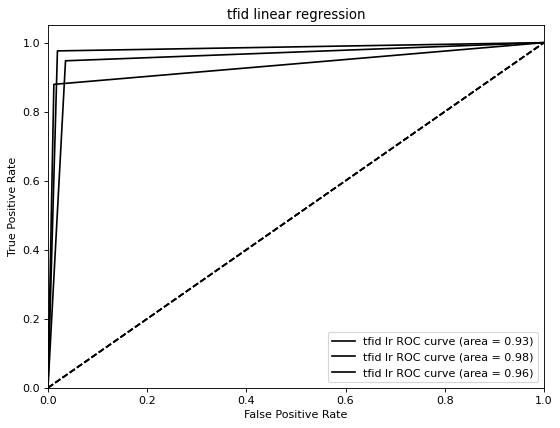

In [ ]:
#plot roc

biy_test = label_binarize(y_test, classes=[0, 1, 2])
n_classes = 3
biy_pred = label_binarize(final_pred, classes=[0, 1, 2])
n_classes = 3
biy_pred

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(biy_test[:,i], biy_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(20,20))
figure(figsize=(8, 6), dpi=80)
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='tfid lr ROC curve (area = %0.2f)' % roc_auc[i],color = 'black')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('tfid linear regression')
    plt.legend(loc="lower right")
    


In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix
newy_test = np.array(y_test)
cm = confusion_matrix(newy_test,final_pred)
print(cm)

[[ 80   0  11]
 [  3 408   7]
 [  4   5 162]]


In [ ]:
import transformers
import shap

# explain the model on two sample inputs
new_model = transformers.pipeline('sentiment-analysis',model=new_model,tokenizer = new_tokenizer, return_all_scores=True)
explainer = shap.Explainer(new_model) 
#s=["In this picture, there are four persons: my father, my mother, my brother and my sister."]
shap_values = explainer(df["text"].iloc[:3].tolist())

# visualize the first prediction's explanation for the POSITIVE output class
shap.plots.text(shap_values[0, :, "POSITIVE"])

In [ ]:
from transformers import BertTokenizer, BertModel
new_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
new_model = BertModel.from_pretrained('bert-base-uncased')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)


new_df = df.drop(['label'], axis='columns')
all_hidden=[]
num_training_steps = len(new_df)


progress_bar = tqdm(range(num_training_steps))
for index, row in new_df.iterrows():
    inputs = new_tokenizer(new_df.text[index], padding="max_length", truncation=True, max_length = 50, return_tensors="pt")
    with torch.no_grad():
        outputs = new_model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    all_hidden.append(last_hidden_states.cpu().numpy().ravel())
    progress_bar.update(1)


  0%|          | 0/2264 [00:00<?, ?it/s]

In [ ]:
from sklearn.cluster import AgglomerativeClustering

clustering= AgglomerativeClustering().fit(all_hidden)
clustering

AgglomerativeClustering()